# Report on weather data

In [ ]:
import sys
import os
import pandas as pd

In [63]:
# git directories

# Josh
gitdir = "/Users/joshd/Documents/GitHub/GA2024_1/"

#Magda
#gitdir =

# Add the directory
module_path = os.path.abspath(gitdir)
sys.path.append(module_path)

from home_messages_db import HomeMessagesDB

db = HomeMessagesDB('sqlite:///myhome.db')

df_st = db.get_smartthings()
df_p1e = db.get_p1e()
df_p1g = db.get_p1g()
df_weather = db.get_weather_data()




In [9]:
# get overview

# gas data
print(df_p1g.shape)

# energy usage (smartthings)
print(df_st.shape)

# weather
print(df_weather.shape)

(80716, 3)
(1182210, 9)
(20424, 9)


In [32]:
df_ins_temp = df_st[df_st["capability"] == "temperatureMeasurement"]

In [33]:
# data types
df_ins_temp['value'] = df_ins_temp['value'].astype(float)

# rename temperature
df_ins_temp.rename(columns={'value': 'temperature'}, inplace=True)

/var/folders/z1/762t94_j4tx1bhtk_g1t9qh80000gn/T/ipykernel_21265/2229040446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ins_temp['value'] = df_ins_temp['value'].astype(float)
/var/folders/z1/762t94_j4tx1bhtk_g1t9qh80000gn/T/ipykernel_21265/2229040446.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ins_temp.rename(columns={'value': 'temperature'}, inplace=True)


## Get daily inside temperature average for smartthings

In [34]:
# Convert epoch_seconds to datetime
df_ins_temp['datetime'] = pd.to_datetime(df_ins_temp['epoch'], unit='s')

# Select only the target column (temperature) and the epoch time
df_target = df_ins_temp[['datetime', 'temperature']]

# Set datetime as index
df_target.set_index('datetime', inplace=True)

# Resample by day and calculate the average temperature
df_daily_inside = df_target.resample('D').mean()

# Reset index to make 'datetime' a column again
df_daily_inside.reset_index(inplace=True)

/var/folders/z1/762t94_j4tx1bhtk_g1t9qh80000gn/T/ipykernel_21265/3757912852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ins_temp['datetime'] = pd.to_datetime(df_ins_temp['epoch'], unit='s')


# Get daily outside temperature for weather data

In [35]:
# data types
df_weather['temperature_2m'] = df_weather['temperature_2m'].astype(float)

df_out_temp = df_weather.copy()

# rename temperature
df_out_temp.rename(columns={'temperature_2m': 'temperature'}, inplace=True)


# Convert epoch_seconds to datetime
df_out_temp['datetime'] = pd.to_datetime(df_out_temp['time'], unit='s')

# Select only the target column (temperature) and the epoch time
df_target = df_out_temp[['datetime', 'temperature']]

# Set datetime as index
df_target.set_index('datetime', inplace=True)

# Resample by day and calculate the average temperature
df_daily_outside = df_target.resample('D').mean()

# Reset index to make 'datetime' a column again
df_daily_outside.reset_index(inplace=True)


## Get daily average for gas usage

### Drop nans !

In [39]:
# data types
df_p1g['total_gas_used'] = df_p1g['total_gas_used'].astype(float)

df_gas = df_p1g.copy()


# drop NaN
rows_with_nans = df_gas[df_gas['total_gas_used'].isna()]

# Drop rows with NaNs
df_gas = df_gas.dropna(subset=['total_gas_used'])


# Display observations that were dropped
print("\nRows that were dropped:")
print(rows_with_nans)


# Convert epoch_seconds to datetime
df_gas['datetime'] = pd.to_datetime(df_out_temp['time'], unit='s')

# Select only the target column (temperature) and the epoch time
df_target = df_gas[['datetime', 'total_gas_used']]

# Set datetime as index
df_target.set_index('datetime', inplace=True)

# Resample by day and calculate the average temperature
df_daily_gas = df_target.resample('D').mean()

# Reset index to make 'datetime' a column again
df_daily_gas.reset_index(inplace=True)

# no idea why, but for 02-02-2024 a nan was averaged
df_daily_gas = df_daily_gas.dropna(subset=['total_gas_used'])



Rows that were dropped:
          id                 time  total_gas_used
0          1  2022-01-01 01:00:00             NaN
1          2  2022-01-01 01:15:00             NaN
2          3  2022-01-01 01:30:00             NaN
3          4  2022-01-01 01:45:00             NaN
4          5  2022-01-01 02:00:00             NaN
...      ...                  ...             ...
80711  80712  2024-04-22 00:45:00             NaN
80712  80713  2024-04-22 01:00:00             NaN
80713  80714  2024-04-22 01:15:00             NaN
80714  80715  2024-04-22 01:30:00             NaN
80715  80716  2024-04-22 01:45:00             NaN

[8494 rows x 3 columns]


# merge data frames to target data frames

In [42]:

df_merge = pd.merge(df_daily_inside, df_daily_outside, on='datetime', how='inner')
df_final = pd.merge(df_merge, df_daily_gas, on='datetime', how='inner')

df_final.rename(columns={'temperature_x': 'temperature_inside'}, inplace=True)
df_final.rename(columns={'temperature_y': 'temperature_outside'}, inplace=True)

## Weather Report

In [84]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

In [68]:
%reset -f


In [70]:
#gitdir = "/Users/magdalenaskrzycki/Desktop/GA2024_1/"

# Josh
gitdir = "/Users/joshd/Documents/GitHub/GA2024_1/"

# Add the directory
module_path = os.path.abspath(gitdir)
sys.path.append(module_path)

from home_messages_db import HomeMessagesDB

db = HomeMessagesDB('sqlite:///myhome.db')

df_st = db.get_smartthings()
df_p1g = db.get_p1g()
df_weather = db.get_weather_data()

In [71]:
# temperature inside

df_ins_temp = df_st[df_st["capability"] == "temperatureMeasurement"]
df_ins_temp = df_ins_temp.copy()
df_ins_temp['value'] = df_ins_temp['value'].astype(float)
df_ins_temp.rename(columns={'value': 'inside temperature'}, inplace=True)
df_ins_temp['datetime'] = pd.to_datetime(df_ins_temp['epoch'], unit='s')
df_ins_temp.set_index('datetime', inplace=True)
df_avg_house_temp_daily = df_ins_temp.resample('D').mean(numeric_only=True)
df_avg_house_temp_daily.reset_index(inplace=True)
df_avg_house_temp_daily = df_avg_house_temp_daily[['datetime', 'inside temperature']]

## results in average inside temperature per hour in October 2022

In [72]:
# temperature outside

df_weather['temperature_2m'] = df_weather['temperature_2m'].astype(float)
df_out_temp = df_weather.copy()
df_out_temp.rename(columns={'temperature_2m': 'temperature'}, inplace=True)
df_out_temp['datetime'] = pd.to_datetime(df_out_temp['time'], unit='s')
df_target = df_out_temp[['datetime', 'temperature']]
df_target.set_index('datetime', inplace=True)
df_daily_outside = df_target.resample('D').mean()
df_daily_outside.reset_index(inplace=True)

# average per hour

In [73]:
df_p1g['total_gas_used'] = df_p1g['total_gas_used'].astype(float)
df_gas = df_p1g.copy()
df_gas = df_gas.dropna(subset=['total_gas_used'])
df_gas['datetime'] = pd.to_datetime(df_gas['time'])
df_target = df_gas[['datetime', 'total_gas_used']]
df_target.set_index('datetime', inplace=True)
df_first = df_target.resample('D').first()
df_last = df_target.resample('D').last()
df_last_shifted = df_last.shift(-1)
df_daily_diff = df_last_shifted['total_gas_used'] - df_first['total_gas_used']
df_daily_diff = df_daily_diff.dropna()
df_daily_diff = df_daily_diff.reset_index()
df_daily_diff.rename(columns={'total_gas_used': 'daily_gas_difference'}, inplace=True)

In [74]:
df_merge = pd.merge(df_avg_house_temp_daily, df_daily_outside, on='datetime', how='inner')
df_final = pd.merge(df_merge, df_daily_diff, on='datetime', how='inner')
df_final = df_final[['datetime','inside temperature', 'temperature','daily_gas_difference']]
df = df_final

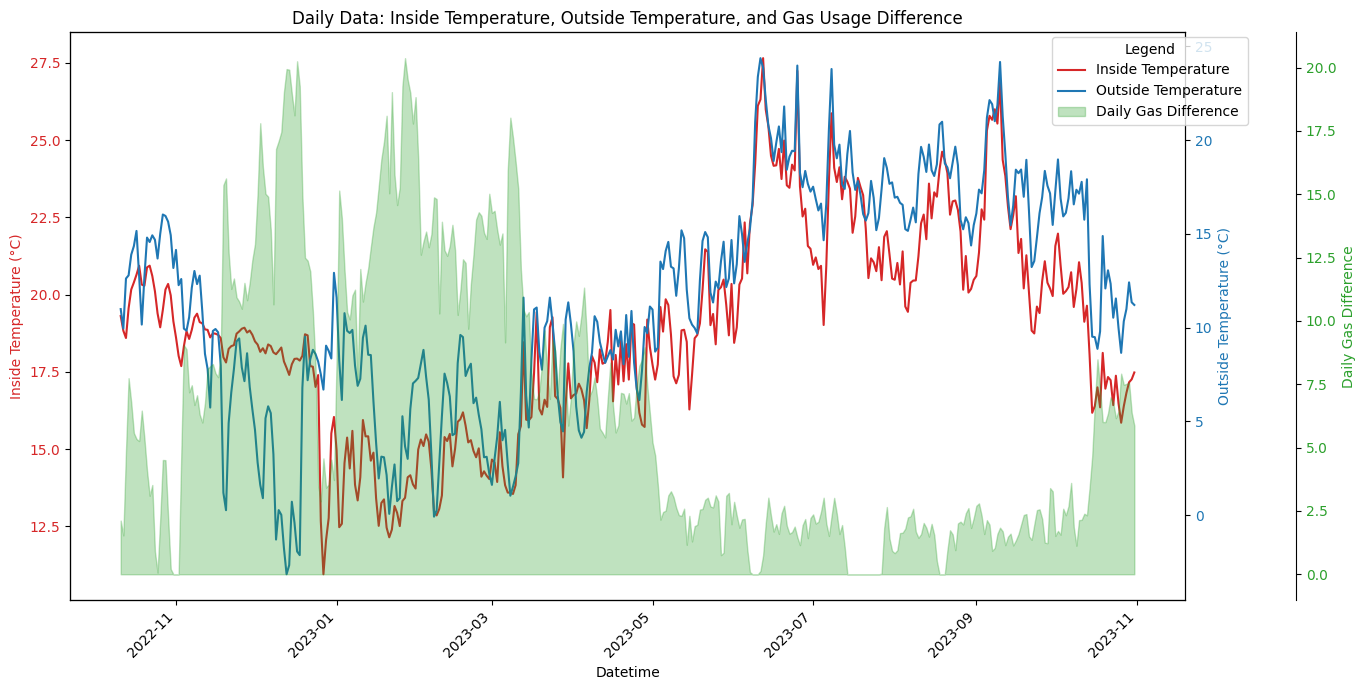

In [78]:
fig, ax1 = plt.subplots(figsize=(14, 7))
color = 'tab:red'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Inside Temperature (°C)', color=color)
ax1.plot(df['datetime'], df['inside temperature'], color=color, label='Inside Temperature')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Outside Temperature (°C)', color=color)
ax2.plot(df['datetime'], df['temperature'], color=color, label='Outside Temperature')
ax2.tick_params(axis='y', labelcolor=color)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 80))
color = 'tab:green'
ax3.fill_between(df['datetime'], 0, df['daily_gas_difference'], color=color, alpha=0.3, label='Daily Gas Difference')
ax3.set_ylabel('Daily Gas Difference', color=color)
ax3.tick_params(axis='y', labelcolor=color)
#ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # One tick per day
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Just show date
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right")
handles, labels = [], []
for ax in [ax1, ax2, ax3]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.75, 0.95), title="Legend")
plt.title('Daily Data: Inside Temperature, Outside Temperature, and Gas Usage Difference')
fig.tight_layout() 
plt.subplots_adjust(right=0.85)  
plt.show()

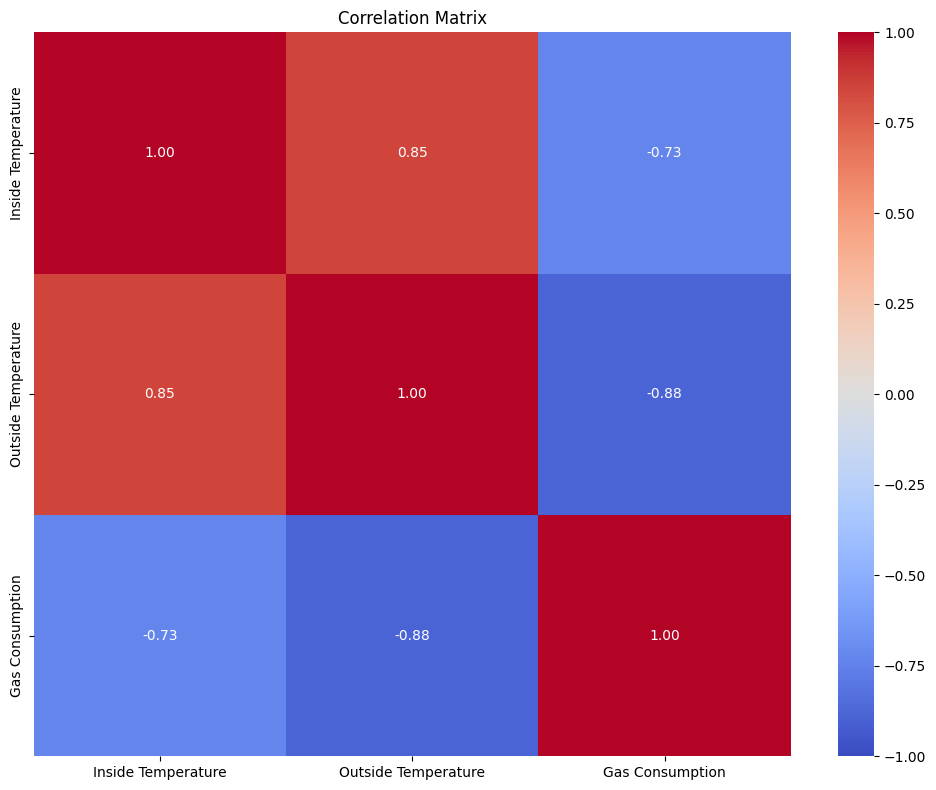

In [79]:
df_renamed = df.rename(columns={
    'inside temperature': 'Inside Temperature',
    'temperature': 'Outside Temperature',
    'daily_gas_difference': 'Gas Consumption'
})
correlation_matrix = df_renamed[['Inside Temperature', 'Outside Temperature', 'Gas Consumption']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10}, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.tight_layout()  
plt.show()


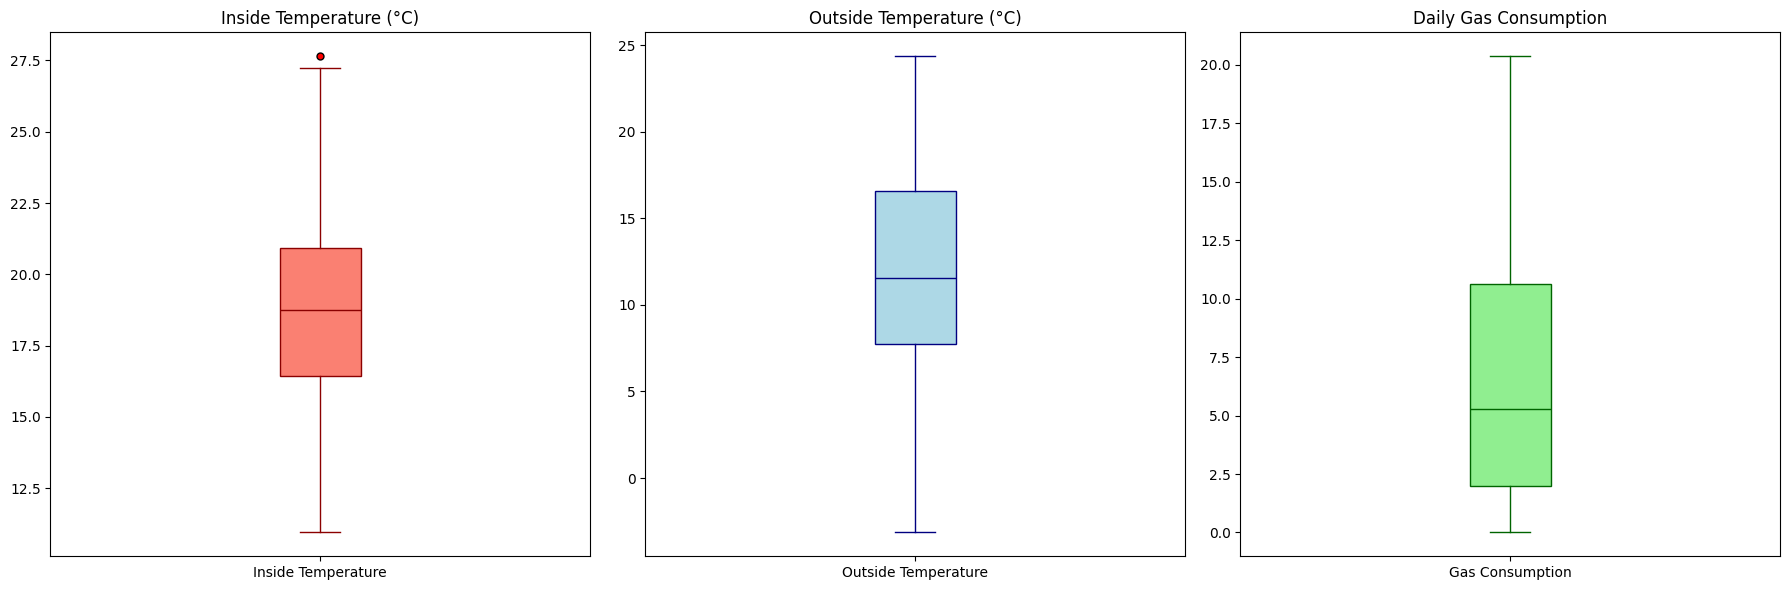

In [85]:
fig = plt.figure(figsize=(18, 6))

# Inside temperature plot
ax1 = fig.add_subplot(131)
ax1.boxplot(df['inside temperature'].dropna(), patch_artist=True,
            boxprops=dict(facecolor='salmon', color='darkred'),
            medianprops=dict(color='darkred'),
            whiskerprops=dict(color='darkred'),
            capprops=dict(color='darkred'),
            flierprops=dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none'))
ax1.set_title('Inside Temperature (°C)')
ax1.set_xticks([1])  
ax1.set_xticklabels(['Inside Temperature'])

# Outside temperature plot
ax2 = fig.add_subplot(132)
ax2.boxplot(df['temperature'].dropna(), patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='navy'),
            medianprops=dict(color='navy'),
            whiskerprops=dict(color='navy'),
            capprops=dict(color='navy'),
            flierprops=dict(marker='o', markerfacecolor='blue', markersize=5, linestyle='none'))
ax2.set_title('Outside Temperature (°C)')
ax2.set_xticks([1]) 
ax2.set_xticklabels(['Outside Temperature'])

# Hourly gas difference plot
ax3 = fig.add_subplot(133)
ax3.boxplot(df['daily_gas_difference'].dropna(), patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='darkgreen'),
            medianprops=dict(color='darkgreen'),
            whiskerprops=dict(color='darkgreen'),
            capprops=dict(color='darkgreen'),
            flierprops=dict(marker='o', markerfacecolor='green', markersize=5, linestyle='none'))
ax3.set_title('Daily Gas Consumption')
ax3.set_xticks([1]) 
ax3.set_xticklabels(['Gas Consumption'])
plt.tight_layout()
plt.show()


In [92]:
daily_stats = df.groupby('datetime')[['daily_gas_difference', 'inside temperature', 'temperature']].mean().reset_index()

daily_stats = daily_stats.drop(columns = ['datetime'])

stats = daily_stats.describe()


# Display the merged data
display(stats)


,daily_gas_difference,inside temperature,temperature
count,386.000000,386.000000,386.000000
mean,6.541049,18.802916,11.638007
std,5.479382,3.297709,5.897117
min,0.000000,10.950806,-3.145833
25%,1.967750,16.436691,7.767708
50%,5.300000,18.733211,11.581250
75%,10.612000,20.910738,16.568750
max,20.374000,27.648758,24.370833


In [86]:
df_clean = df.dropna(subset=['inside temperature', 'temperature', 'daily_gas_difference'])
X = df_clean[['inside temperature', 'temperature']]  
X = sm.add_constant(X)  
y = df_clean['daily_gas_difference']  
model = sm.OLS(y, X).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     daily_gas_difference   R-squared:                       0.782
Model:                              OLS   Adj. R-squared:                  0.780
Method:                   Least Squares   F-statistic:                     685.2
Date:                  Thu, 06 Jun 2024   Prob (F-statistic):          3.01e-127
Time:                          18:27:40   Log-Likelihood:                -910.19
No. Observations:                   386   AIC:                             1826.
Df Residuals:                       383   BIC:                             1838.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

In [87]:
df_clean = df[['inside temperature', 'temperature', 'daily_gas_difference']].dropna()
df_clean['inside temperature'] = df_clean['inside temperature'].astype(float)
df_clean['temperature'] = df_clean['temperature'].astype(float)
df_clean['daily_gas_difference'] = df_clean['daily_gas_difference'].astype(float)
correlation_matrix = df_clean[['temperature', 'daily_gas_difference']].corr()
print(correlation_matrix)
X = df_clean[['temperature', 'daily_gas_difference']]
X = sm.add_constant(X)  
y = df_clean['inside temperature']
model = sm.OLS(y, X).fit()
print(model.summary())

                      temperature  daily_gas_difference
temperature              1.000000             -0.883658
daily_gas_difference    -0.883658              1.000000
                            OLS Regression Results                            
Dep. Variable:     inside temperature   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     486.6
Date:                Thu, 06 Jun 2024   Prob (F-statistic):          6.98e-106
Time:                        18:29:02   Log-Likelihood:                -763.77
No. Observations:                 386   AIC:                             1534.
Df Residuals:                     383   BIC:                             1545.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err

In [ ]:
# Independent t-test
inside_temp = df['inside temperature'].dropna()
outside_temp = df['temperature'].dropna()
t_stat_ind, p_value_ind = stats.ttest_ind(inside_temp, outside_temp)
print(f"Independent t-test - T-statistic: {t_stat_ind}, P-value: {p_value_ind}")
# Paired t-test
paired_data = df.dropna(subset=['inside temperature', 'temperature'])
inside_temp_paired = paired_data['inside temperature']
outside_temp_paired = paired_data['temperature']
t_stat_paired, p_value_paired = stats.ttest_rel(inside_temp_paired, outside_temp_paired)
print(f"Paired t-test - T-statistic: {t_stat_paired}, P-value: {p_value_paired}")

Independent t-test - T-statistic: 46.773759301398954, P-value: 5.678527570913212e-246
Paired t-test - T-statistic: 54.526081947273894, P-value: 1.192839814470349e-201
